<a href="https://colab.research.google.com/github/OweT1/personal/blob/main/Stock_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Files:
- data.parquet/data.csv (.parquet format is good for efficient loading and saving)
    - The main dataset containing stock price, trade volume, news events and news sentiment for S&P 500 companies during the period Oct 2020-Jul 2022
    - 217811 samples in total
    - Total 26 features per sample
    - Prediction Task:
        - Focus on prediction the following 4 features: "Open" (opening price on the day), "Close" (closing price of the day), "High" (highest price on that day), "Low" (lowest price on that day). If you predicting for day X, then you cannot use any of these 4 feature values of day X as model input
        - If you are predicting for day X, then you should also use some attributes of previous N (experiment with different values of N) days (remember that this is a time series task -> prediction of today is also affected by the occurrences of the near past). These attributes may include "Open", "Close", "High" and "Low" features as well.
- sp500wiki.parquet/sp500wiki.csv
    - List of S&P 500 companies as of July 2022 and various metadata in tabular format
    - Contains information for over 500 companies (524 rows in total)
    - 10 attributes per company (10 columns)
    - You can use these attributes as assisting feature when performing prediction task on a particular day for a particular company

# Additional Information:
- "Symbol" which denotes the company brand, is the common feature between the two datasets
- Missing values are there in the dataset
- Categorical, discrete and continuous attributes exist in the dataset
- The prediction tasks are regression tasks
- Make sure that train and test data have minimum information leakage (this is something you need to think about deeply)  

# Load Necessary Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# !ls /content/drive/MyDrive/'Colab Datasets'/'Stock Market'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Colab Datasets/Stock Market/data.parquet")
sup = pd.read_parquet("/content/drive/MyDrive/Colab Datasets/Stock Market/sp500wiki.parquet")

In [ ]:
print(df.head())
print(sup.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
2020-10-01  160.669998  161.899994  157.720001  158.789993  149.612045   
2020-10-02  156.470001  161.940002  156.250000  160.360001  151.091309   
2020-10-05  162.250000  163.500000  161.759995  162.750000  153.343170   
2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   

               Volume Symbol Security  GICS Sector         GICS Sub-Industry  \
Date                                                                           
2020-09-30  3056900.0    MMM       3M  Industrials  Industrial Conglomerates   
2020-10-01  1989100.0    MMM       3M  Industrials  Industrial Conglomerates   
2020-10-02  1768600.0    MMM       3M  Industrials  Industrial Conglomerates   
2020-10-05  1457000.0    MMM       3M  Industrials  Industrial Conglomerates   
2

In [ ]:
print(df.dtypes)

Open                             float64
High                             float64
Low                              float64
Close                            float64
Adj Close                        float64
Volume                           float64
Symbol                            object
Security                          object
GICS Sector                       object
GICS Sub-Industry                 object
News - All News Volume           float64
News - Volume                    float64
News - Positive Sentiment        float64
News - Negative Sentiment        float64
News - New Products              float64
News - Layoffs                   float64
News - Analyst Comments          float64
News - Stocks                    float64
News - Dividends                 float64
News - Corporate Earnings        float64
News - Mergers & Acquisitions    float64
News - Store Openings            float64
News - Product Recalls           float64
News - Adverse Events            float64
News - Personnel

In [ ]:
print(min(df.index))

2020-09-30 00:00:00


# Check for NA Values
At first, I thought that it might have been for the starting date of each stock, but it turns out to all correlate with the data points on 2020-09-30, which turns out to be the starting point of all our data.

In [ ]:
print(len(pd.unique(df['Symbol'])))
print(df.isna().sum())

495
Open                               0
High                               0
Low                                0
Close                              0
Adj Close                          0
Volume                             0
Symbol                             0
Security                           0
GICS Sector                        0
GICS Sub-Industry                  0
News - All News Volume           493
News - Volume                    493
News - Positive Sentiment        493
News - Negative Sentiment        493
News - New Products              493
News - Layoffs                   493
News - Analyst Comments          493
News - Stocks                    493
News - Dividends                 493
News - Corporate Earnings        493
News - Mergers & Acquisitions    493
News - Store Openings            493
News - Product Recalls           493
News - Adverse Events            493
News - Personnel Changes         493
News - Stock Rumors              493
dtype: int64


In [ ]:
print(df[df.index == "2020-09-30"])
print(df[df.index == "2020-09-30"].isna().sum())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
2020-09-30   53.709999   54.020000   52.720001   52.799999   51.231228   
2020-09-30  105.989998  109.480003  105.739998  108.830002  106.019371   
2020-09-30   87.000000   88.440002   86.809998   87.589996   80.923454   
2020-09-30  275.119995  280.880005  272.220001  277.059998  277.059998   
...                ...         ...         ...         ...         ...   
2020-09-30   91.120003   92.529999   90.760002   91.300003   88.541023   
2020-09-30  258.070007  259.390015  250.449997  252.460007  252.460007   
2020-09-30  129.902908  133.912628  129.699036  132.174759  130.564957   
2020-09-30   29.080000   29.570000   28.870001   29.219999   27.909163   
2020-09-30  162.919998  166.789993  162.750000  165.369995  163.708176   

               Volume Symbol         

# Dropping of Features
There are some features that would not likely be applicable / usable in our modelling. Hence, we would get rid of `Security`, `GICS Sector`, `GICS Sub-Industry` as they seem to not be useful in our analysis of the various stocks.

In [ ]:
new_df = df.drop(['Security', 'GICS Sector', 'GICS Sub-Industry'], axis = 1)

print(new_df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
2020-10-01  160.669998  161.899994  157.720001  158.789993  149.612045   
2020-10-02  156.470001  161.940002  156.250000  160.360001  151.091309   
2020-10-05  162.250000  163.500000  161.759995  162.750000  153.343170   
2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   

               Volume Symbol  News - All News Volume  News - Volume  \
Date                                                                  
2020-09-30  3056900.0    MMM                     NaN            NaN   
2020-10-01  1989100.0    MMM                589369.0           47.0   
2020-10-02  1768600.0    MMM                506082.0           43.0   
2020-10-05  1457000.0    MMM                489872.0           50.0   
2020-10-06  2021900.0    MMM                550713.0   

# Filling of NA values (Not necessary)
Since the NA values occur on the first day of our dataset for the features that are News, we will replace them to be the mean of all the values in that column and `Symbol`.

In theory, this should be done after the data has been split to prevent data leakage. In this case, it does not matter as much since we will drop the rows affected later on.

In [ ]:
# columns = new_df.columns[new_df.columns.str.startswith("News")]
# for column in columns:
#   new_df[column] = new_df.groupby("Symbol")[column].transform(lambda x: x.fillna(x.mean()))
#   #print(new_df.groupby("Symbol")[column].mean())

# print(new_df.head())
# print(new_df.isna().sum())

# Lagging of values
We will do lagging of `Open`, `High`, `Low`, `Close` so that we are able to predict these 4 values in the end.

In [ ]:
lag_amt = 2
columns = ["Open", "High", "Low", "Close"]

for column in columns:
  for lag in range(1, lag_amt+1):
    col_name = f"{column}_Lag{lag}"
    new_df[col_name] = new_df.groupby("Symbol")[column].transform(lambda x: x.shift(lag))

print(new_df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
2020-10-01  160.669998  161.899994  157.720001  158.789993  149.612045   
2020-10-02  156.470001  161.940002  156.250000  160.360001  151.091309   
2020-10-05  162.250000  163.500000  161.759995  162.750000  153.343170   
2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   

               Volume Symbol  News - All News Volume  News - Volume  \
Date                                                                  
2020-09-30  3056900.0    MMM                     NaN            NaN   
2020-10-01  1989100.0    MMM                589369.0           47.0   
2020-10-02  1768600.0    MMM                506082.0           43.0   
2020-10-05  1457000.0    MMM                489872.0           50.0   
2020-10-06  2021900.0    MMM                550713.0   

# Simple Moving Average
We will introduce another feature, a Simple Moving Average of the 4 prices, `Close`, `Open`, `High` and `Low` over 5 days.

In [ ]:
days = 5
columns = ["Open", "High", "Low", "Close"]

for column in columns:
  new_df[f"SMA5_{column}"] = new_df.groupby("Symbol")[column].transform(lambda x: x.rolling(days).mean())

print(new_df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-09-30  160.929993  163.100006  158.610001  160.179993  150.921692   
2020-10-01  160.669998  161.899994  157.720001  158.789993  149.612045   
2020-10-02  156.470001  161.940002  156.250000  160.360001  151.091309   
2020-10-05  162.250000  163.500000  161.759995  162.750000  153.343170   
2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   

               Volume Symbol  News - All News Volume  News - Volume  \
Date                                                                  
2020-09-30  3056900.0    MMM                     NaN            NaN   
2020-10-01  1989100.0    MMM                589369.0           47.0   
2020-10-02  1768600.0    MMM                506082.0           43.0   
2020-10-05  1457000.0    MMM                489872.0           50.0   
2020-10-06  2021900.0    MMM                550713.0   

# Dropping of NaN values
We will drop the rows with NaN values so that we can do our predictions with all the features available.

In [ ]:
new_df = new_df.dropna()

print(new_df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   
2020-10-07  165.100006  167.750000  164.410004  166.490005  156.866989   
2020-10-08  167.300003  168.149994  166.130005  167.710007  158.016479   
2020-10-09  168.880005  170.479996  167.949997  169.300003  159.514557   
2020-10-12  169.470001  170.610001  168.119995  168.649994  158.902130   

               Volume Symbol  News - All News Volume  News - Volume  \
Date                                                                  
2020-10-06  2021900.0    MMM                550713.0           50.0   
2020-10-07  2155400.0    MMM                573739.0           32.0   
2020-10-08  1902600.0    MMM                565295.0           36.0   
2020-10-09  2015500.0    MMM                527671.0           36.0   
2020-10-12  1533600.0    MMM                452574.0   

# Modelling
With these values, we will now create our prediction model. Firstly, we will need to split the data accordingly. We will do so by partitioning the data by their `Symbol`, and then use the first 80% of the data as training data.

We will use a standard Linear Regression model using `sklearn`'s `LinearRegression()` to train using the training data, and predict the remaining 20% of the data. Afterwards, we will use the model to predict the remaining 20% of the dataset, and calculate the Mean Absolute Loss generated using `sklearn`'s `mean_absolute_loss`.

In [ ]:
# Check the number of Symbols there are
print(len(new_df["Symbol"].unique()))
print(new_df["Symbol"].unique())

495
['MMM' 'AOS' 'ABT' 'ABBV' 'ABMD' 'ACN' 'ATVI' 'ADM' 'ADBE' 'ADP' 'AAP'
 'AES' 'AFL' 'A' 'APD' 'AKAM' 'ALK' 'ALB' 'ARE' 'ALGN' 'ALLE' 'LNT' 'ALL'
 'GOOGL' 'GOOG' 'MO' 'AMZN' 'AMCR' 'AMD' 'AEE' 'AAL' 'AEP' 'AXP' 'AIG'
 'AMT' 'AWK' 'AMP' 'ABC' 'AME' 'AMGN' 'APH' 'ADI' 'ANSS' 'AON' 'APA'
 'AAPL' 'AMAT' 'APTV' 'ANET' 'AJG' 'AIZ' 'T' 'ATO' 'ADSK' 'AZO' 'AVB'
 'AVY' 'BKR' 'BAC' 'BBWI' 'BAX' 'BDX' 'WRB' 'BBY' 'BIO' 'TECH' 'BIIB'
 'BLK' 'BK' 'BA' 'BKNG' 'BWA' 'BXP' 'BSX' 'BMY' 'AVGO' 'BR' 'CHRW' 'CDNS'
 'CZR' 'CPT' 'CPB' 'COF' 'CAH' 'KMX' 'CCL' 'CARR' 'CTLT' 'CAT' 'CBOE'
 'CBRE' 'CDW' 'CE' 'CNC' 'CNP' 'CDAY' 'CF' 'CRL' 'SCHW' 'CHTR' 'CVX' 'CMG'
 'CB' 'CHD' 'CI' 'CINF' 'CTAS' 'CSCO' 'C' 'CFG' 'CTXS' 'CLX' 'CME' 'CMS'
 'KO' 'CTSH' 'CL' 'CMCSA' 'CMA' 'CAG' 'COP' 'ED' 'STZ' 'CEG' 'COO' 'CPRT'
 'GLW' 'CTVA' 'COST' 'CTRA' 'CCI' 'CSX' 'CMI' 'CVS' 'DHI' 'DHR' 'DRI'
 'DVA' 'DE' 'DAL' 'XRAY' 'DVN' 'DXCM' 'FANG' 'DLR' 'DFS' 'DISH' 'DIS' 'DG'
 'DLTR' 'D' 'DPZ' 'DOV' 'DOW' 'DTE' 'DUK' 'DRE' 'DD' 'DXC' '

In [ ]:
stocks = new_df["Symbol"].unique()
train_split = 0.8
columns = ["Open", "High", "Low", "Close"]
output_df = pd.DataFrame()

for stock in stocks:
  stock_df = new_df[new_df["Symbol"] == stock]
  total_len = len(stock_df)
  train_ind = int(total_len * 0.8)
  X_train, y_train = stock_df.drop(columns + ["Symbol"], axis = 1)[:train_ind], stock_df[columns][:train_ind]
  X_test, y_test = stock_df.drop(columns + ["Symbol"], axis = 1)[train_ind:], stock_df[columns][train_ind:]

  lin_reg = LinearRegression()
  lin_reg.fit(X_train, y_train)
  y_pred = np.concatenate((lin_reg.predict(X_train), lin_reg.predict(X_test)), axis = 0)
  y_pred_df = pd.DataFrame(y_pred, columns = ["Open_pred", "High_pred", "Low_pred", "Close_pred"])

  temp_df = pd.concat([stock_df.reset_index(), y_pred_df.reset_index()], axis = 1)
  output_df = pd.concat([output_df, temp_df], axis = 0)

In [ ]:
print(output_df.columns)

output_df = output_df.drop("index", axis = 1)

print(output_df.head())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Symbol',
       'News - All News Volume', 'News - Volume', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'Open_Lag1', 'Open_Lag2', 'High_Lag1',
       'High_Lag2', 'Low_Lag1', 'Low_Lag2', 'Close_Lag1', 'Close_Lag2',
       'SMA5_Open', 'SMA5_High', 'SMA5_Low', 'SMA5_Close', 'index',
       'Open_pred', 'High_pred', 'Low_pred', 'Close_pred'],
      dtype='object')
        Date        Open        High         Low       Close   Adj Close  \
0 2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   
1 2020-10-07  165.100006  167.750000  164.410004  166.490005  1

# Model Evaluation
Now, we will take a look at our predictions and see how the model does at predicting the trends in the stock market.

We will do so by looking at the `Open`, `High`, `Low`, `Close` data values and predictions for 1 stock with the symbol `MMM`.

In [ ]:
MMM_df = output_df[output_df["Symbol"] == "MMM"]

print(MMM_df)

          Date        Open        High         Low       Close   Adj Close  \
0   2020-10-06  163.440002  165.699997  161.830002  162.229996  152.853195   
1   2020-10-07  165.100006  167.750000  164.410004  166.490005  156.866989   
2   2020-10-08  167.300003  168.149994  166.130005  167.710007  158.016479   
3   2020-10-09  168.880005  170.479996  167.949997  169.300003  159.514557   
4   2020-10-12  169.470001  170.610001  168.119995  168.649994  158.902130   
..         ...         ...         ...         ...         ...         ...   
432 2022-06-24  131.529999  134.550003  131.240005  134.330002  134.330002   
433 2022-06-27  134.410004  134.669998  132.289993  132.800003  132.800003   
434 2022-06-28  133.860001  134.570007  130.149994  130.330002  130.330002   
435 2022-06-29  130.000000  130.339996  128.809998  129.770004  129.770004   
436 2022-06-30  128.710007  130.210007  127.300003  129.410004  129.410004   

        Volume Symbol  News - All News Volume  News - Volume  .

## MMM Prices
We will use a for loop to iterate through the 4 target variables, `Open`, `High`, `Low`, `Close` to plot the graph and report the Mean Absolute Error using `sklearn`'s `mean_absolute_error`.

<ipython-input-120-e8d2fb908518>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMM_temp[f'{column}_pred'][:train_ind] = np.nan


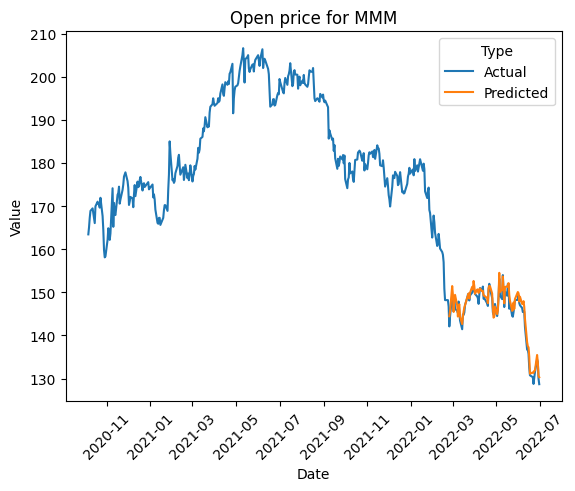

Mean Absolute Error: 1.039


<ipython-input-120-e8d2fb908518>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMM_temp[f'{column}_pred'][:train_ind] = np.nan


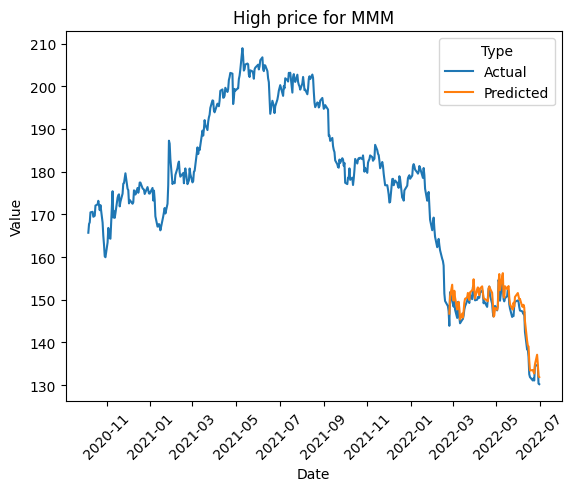

Mean Absolute Error: 1.428


<ipython-input-120-e8d2fb908518>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMM_temp[f'{column}_pred'][:train_ind] = np.nan


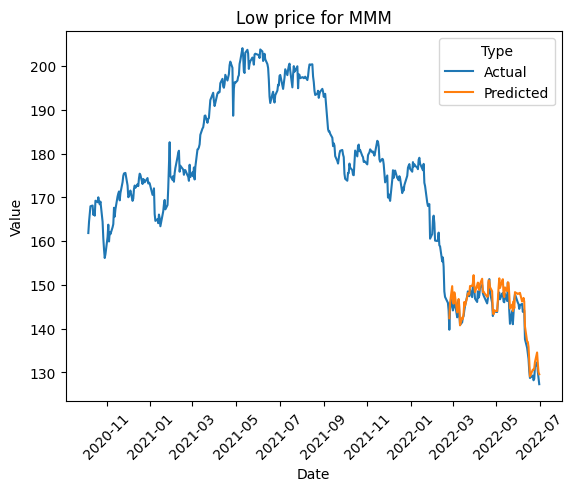

Mean Absolute Error: 1.557


<ipython-input-120-e8d2fb908518>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MMM_temp[f'{column}_pred'][:train_ind] = np.nan


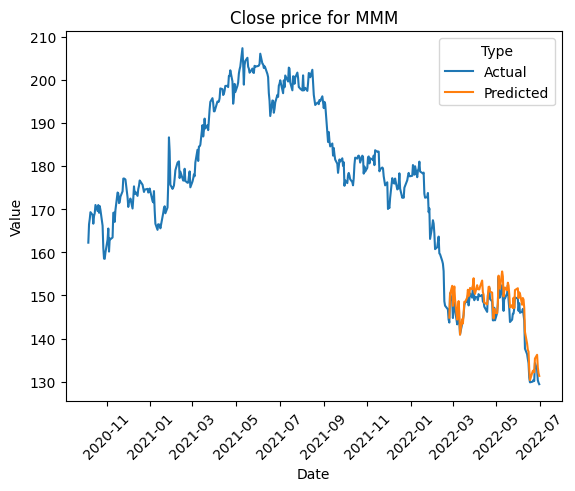

Mean Absolute Error: 1.931


In [ ]:
train_ind = int(train_split * len(MMM_df)) # train_split is defined to be 0.8 above
columns = ["Open", "High", "Low", "Close"]

for column in columns:
  MMM_temp = MMM_df[['Date', column, f'{column}_pred']]
  MMM_temp[f'{column}_pred'][:train_ind] = np.nan
  MMM_temp_long = pd.melt(MMM_temp, ['Date'], var_name = 'Type', value_name = 'Value')
  MMM_temp_long['Type'] = MMM_temp_long['Type'].replace({column:'Actual', f'{column}_pred':'Predicted'})

  g = sns.lineplot(MMM_temp_long, x = 'Date', y = 'Value', hue = 'Type')
  g.set(title = f"{column} price for MMM")
  plt.xticks(rotation = 45)
  plt.show()
  print(f"{column} Mean Absolute Error: " + str(round(mean_absolute_error(MMM_temp[f"{column}"][train_ind:], MMM_temp[f"{column}_pred"][train_ind:]), 3)))